#### This notebook plos the impact loss by equal shares across different impact areas in terms of 4 proposed impact metrics - budget share, winning rate, cost representation and project representation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [2]:
# use this code block to set column and row viewing size/width
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 30)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

pd.options.display.float_format = '{:.4f}'.format

In [3]:
# read the metadata csv
pbsummary_df = pd.read_csv('../metadata.csv', delimiter=';')
pbsummary_df = pbsummary_df.drop_duplicates()
pbsummary_df

pbsummary_aarau = pd.read_csv('../metadata_aarau.csv', delimiter=';')
pbsummary_df = pd.concat([pbsummary_df, pbsummary_aarau], ignore_index=True)

pbsummary_df['subunit'].fillna(value='all', inplace=True)

In [4]:
# Get election id and vote type, so we know better to segragate approval and score votings
pbsummary_with_vote_type = pbsummary_df[['election_id', 'vote_type']]
print(pbsummary_with_vote_type.head())
print(pbsummary_with_vote_type['vote_type'].value_counts())

   election_id   vote_type
0            1  cumulative
1            2  cumulative
2            3  cumulative
3            4  cumulative
4            5  cumulative
vote_type
approval      613
cumulative    104
ordinal        95
Name: count, dtype: int64


In [5]:
# reading the projects CSV and loading to dataframe
pbprojects_df = pd.read_csv('../projects.csv', delimiter=';')
pbprojects_df.drop_duplicates(inplace=True)
print(pbprojects_df.shape)

pbprojects_aarau = pd.read_csv('../projects_aarau.csv', delimiter=';')
pbprojects_df = pd.concat([pbprojects_df, pbprojects_aarau], ignore_index=True)

# merge the column vote_type into pbprojects_df
pbprojects_df = pd.merge(pbprojects_df, pbsummary_with_vote_type, on='election_id', how='inner')
print(pbprojects_df.shape)

pbprojects_df.head()

(19077, 21)
(19110, 22)


,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type
0,1,France,Toulouse,ARENES,2019,1,7000,1494,215,NaN,NaN,Compostons ensemble !,NaN,NaN,1000000.0000,0.7000,True,True,True,NaN,NaN,cumulative
1,1,France,Toulouse,BELLEFONTAINE MILAN,2019,2,35000,1494,26,NaN,NaN,Panneau d'affichage électronique extérieur,NaN,NaN,1000000.0000,3.5000,False,False,False,NaN,NaN,cumulative
2,1,France,Toulouse,ARENES,2019,3,50000,1494,92,NaN,NaN,Eclairage public d’un chemin piéton-vélo rue Ella Maillart,NaN,NaN,1000000.0000,5.0000,True,False,True,NaN,NaN,cumulative
3,1,France,Toulouse,PRADETTES,2019,4,390000,1494,471,NaN,NaN,"Tous à la Ramée à vélo ! A pied, en trottinette et rollers !",NaN,NaN,1000000.0000,39.0000,False,True,False,NaN,NaN,cumulative
4,1,France,Toulouse,NEGRENEYS,2019,5,168000,1494,205,NaN,NaN,Le parc des Anges vu par ses usagers,NaN,NaN,1000000.0000,16.8000,True,True,True,NaN,NaN,cumulative


In [6]:
# Check for projects where cost of a given project is zero

print("Projects with zero costs: ", pbprojects_df[pbprojects_df['cost'] == 0])

# Currently returns a single project ID which has been commented as been removed by City Council
invalid_projects = pbprojects_df[pbprojects_df['cost'] == 0][['project_id','election_id']]
print(invalid_projects)

# Excluding that single project id by checking with particular election id and project id
valid_pbprojects_df = pbprojects_df[~(pbprojects_df['project_id'].isin(invalid_projects['project_id']) & (pbprojects_df['election_id'].isin(invalid_projects['election_id'])))]
print(pbprojects_df.shape)
print(valid_pbprojects_df.shape)

Projects with zero costs:       election_id country    unit           subunit  instance project_id  cost  \
893           72  Poland  Gdynia  Grabówek | large      2020          5     0   

     project_voters_count  votes  score category  \
893                  1511     18    NaN      NaN   

                                                        name  englishName  \
893  PROJECT WAS REMOVED BY THE CITY FOR VIOLATING THE RULES          NaN   

    target  total_budget  budget_percent  is_mes_winner  is_greedy_winner  \
893    NaN   295110.0000          0.0000           True              True   

     is_phragmen_winner  latitude  longitude vote_type  
893                True       NaN        NaN  approval  
    project_id  election_id
893          5           72
(19110, 22)
(19109, 22)


In [7]:
# setting up vote_percent column
print(valid_pbprojects_df.shape)
valid_pb_projects_total_selections = valid_pbprojects_df.groupby(['election_id'])['votes'].sum().reset_index()
print(valid_pb_projects_total_selections.shape)
valid_pb_projects_total_selections.rename(columns={'votes': 'total_votes_selection'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_total_selections, on='election_id', how='inner')
valid_pbprojects_df['vote_percent'] = round((valid_pbprojects_df['votes'] / valid_pbprojects_df['total_votes_selection'] * 100),3)
print(valid_pbprojects_df.shape)

(19109, 22)
(812, 2)
(19109, 24)


In [8]:
aarau_election_id = valid_pbprojects_df[valid_pbprojects_df['country'] == 'Switzerland'].groupby(['election_id']).first().reset_index()['election_id']
green_budget_election_id = valid_pbprojects_df[valid_pbprojects_df['unit'] == 'Wieliczka'].groupby(['election_id']).first().reset_index()['election_id']


In [9]:
print("Distinct election IDs are: ", valid_pbprojects_df['election_id'].nunique())
valid_pbprojects_df_grouped_election = valid_pbprojects_df.groupby(['election_id','is_mes_winner'])['cost'].agg(['sum']).reset_index()
print(valid_pbprojects_df_grouped_election.head())
print(valid_pbprojects_df_grouped_election.shape)
print("Unique election IDs after grouping total costs: ", valid_pbprojects_df_grouped_election['election_id'].nunique())
mes_winners_grouped_project_count = valid_pbprojects_df_grouped_election[valid_pbprojects_df_grouped_election['is_mes_winner'] == True]
print(mes_winners_grouped_project_count.shape)

Distinct election IDs are:  812
   election_id  is_mes_winner       sum
0            1          False   1455000
1            1           True    997000
2            2          False  23588713
3            2           True   2350560
4            3          False    804294
(1563, 3)
Unique election IDs after grouping total costs:  812
(812, 3)


In [10]:
# setting additional column for used budget with MES aggregation
print(valid_pbprojects_df.shape)

elections_with_mes_winners = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True]
elections_with_greedy_winners = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner'] == True]
print("Elections with MES winners: ", elections_with_mes_winners['election_id'].nunique())
print("Elections with Greedy Winners: ", elections_with_greedy_winners['election_id'].nunique())

# Getting the total budget usage for MES winning projects of each election_id (grouped) and adding a new column to denote that value
valid_pb_projects_mes_budget_usage = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True].groupby(['election_id'])['cost'].sum().reset_index()
valid_pb_projects_mes_budget_usage.rename(columns={'cost': 'mes_total_budget_usage'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_mes_budget_usage, on='election_id', how='inner')
valid_pbprojects_df['mes_budget_usage_percent'] = round((valid_pbprojects_df['mes_total_budget_usage'] / valid_pbprojects_df['total_budget'] * 100),3)
print(valid_pbprojects_df.shape)

# Getting the total budget usage for utilitarian greedy winning projects of each election_id (grouped) and adding a new column to denote that value
valid_pb_projects_greedy_budget_usage = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner']].groupby(['election_id'])['cost'].sum().reset_index()
valid_pb_projects_greedy_budget_usage.rename(columns={'cost': 'greedy_total_budget_usage'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_greedy_budget_usage, on='election_id', how='inner')
valid_pbprojects_df['greedy_budget_usage_percent'] = round((valid_pbprojects_df['greedy_total_budget_usage'] / valid_pbprojects_df['total_budget'] * 100),3)
print(valid_pbprojects_df.shape)

(19109, 24)
Elections with MES winners:  812
Elections with Greedy Winners:  812
(19109, 26)
(19109, 28)


## Fill empty values for category with the label 'uncategorized' to aid in further data analysis

In [11]:
valid_pbprojects_df['category'].value_counts()

# Checking to see if there are empty values for category in the entire project dataset
na_category_count = valid_pbprojects_df['category'].isna().sum()
print("Empty category values for PB projects are: ", na_category_count)

# Fill such empty values of category with the label uncategorized, so that it can aid in further data preprocessing
valid_pbprojects_df['category'].fillna('uncategorized', inplace=True)


print("Emtpy category values after filling na: ", valid_pbprojects_df['category'].isna().sum())
print("`uncategorized` category count for valid pb projects: ", valid_pbprojects_df[valid_pbprojects_df['category'] == 'uncategorized'].shape[0])

Empty category values for PB projects are:  8182
Emtpy category values after filling na:  0
`uncategorized` category count for valid pb projects:  8182


## The column `category` contains multiple categories embedded into the column separated by commas, let's do some data processing so that we select only first signifiying category
## We store this into a new column called `major_category`

In [12]:
def trimCategoryText(category_text):
    return category_text.split(',')[0]

valid_pbprojects_df['major_category'] = valid_pbprojects_df['category'].apply(trimCategoryText)
valid_pbprojects_df['major_category'].nunique()

print("Empty major category: ", valid_pbprojects_df['major_category'].isna().sum())
print("---------------------------------------------------------------")
print("Counts for each major category: \n", valid_pbprojects_df['major_category'].value_counts())
print("---------------------------------------------------------------")
print("Major categories sum: ", valid_pbprojects_df['major_category'].value_counts().sum())



Empty major category:  0
---------------------------------------------------------------
Counts for each major category: 
 major_category
uncategorized               8182
education                   2438
public space                2068
urban greenery              1484
sport                       1296
public transit and roads    1240
culture                     1126
environmental protection     717
welfare                      320
health                       238
Name: count, dtype: int64
---------------------------------------------------------------
Major categories sum:  19109


## Create additional columns for each category label

In [13]:
# Split the Categories column and create a set of unique categories
categories_set = set(category.strip() for categories in valid_pbprojects_df['category'] for category in categories.split(','))

# Create new columns with default value 0
for category in categories_set:
    valid_pbprojects_df[f'category_{category}'] = 0

# Iterate through rows and update the new columns
for index, row in valid_pbprojects_df.iterrows():
    categories = row['category'].split(',')
    for category in categories:
        valid_pbprojects_df.at[index, f'category_{category.strip()}'] = 1
    
    if(len(categories) == 1 and (categories[0] == 'uncategorized')):
        valid_pbprojects_df.at[index, 'category_labels_count'] = 0
    else:
        valid_pbprojects_df.at[index, 'category_labels_count'] = int(len(categories))

valid_pbprojects_df.tail()

,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type,total_votes_selection,vote_percent,mes_total_budget_usage,mes_budget_usage_percent,greedy_total_budget_usage,greedy_budget_usage_percent,major_category,category_uncategorized,category_health,category_public space,category_welfare,category_education,category_public transit and roads,category_urban greenery,category_culture,category_environmental protection,category_sport,category_labels_count
19104,1000,Switzerland,Aarau,Aarau,2023,18,5000,1703,88,146.0000,"health,education,welfare",Processing birth,NaN,"adults,families with children",50000.0000,10.0000,False,False,False,NaN,NaN,cumulative,8262,1.0650,49400,98.8000,49600,99.2000,health,0,1,0,1,1,0,0,0,0,0,3.0000
19105,1000,Switzerland,Aarau,Aarau,2023,17,3500,1703,67,102.0000,welfare,Senior Meeting,NaN,elderly,50000.0000,7.0000,False,False,False,NaN,NaN,cumulative,8262,0.8110,49400,98.8000,49600,99.2000,welfare,0,0,0,1,0,0,0,0,0,0,1.0000
19106,1000,Switzerland,Aarau,Aarau,2023,27,4000,1703,69,97.0000,"public space,public transit and roads",New edition of Telli-Map,NaN,"children,families with children,elderly",50000.0000,8.0000,False,False,False,NaN,NaN,cumulative,8262,0.8350,49400,98.8000,49600,99.2000,public space,0,0,1,0,0,1,0,0,0,0,2.0000
19107,1000,Switzerland,Aarau,Aarau,2023,19,500,1703,56,85.0000,"welfare,education,health",Ways of Remembering,NaN,"youth,adults,elderly",50000.0000,1.0000,True,False,True,NaN,NaN,cumulative,8262,0.6780,49400,98.8000,49600,99.2000,welfare,0,1,0,1,1,0,0,0,0,0,3.0000
19108,1000,Switzerland,Aarau,Aarau,2023,6,4000,1703,44,85.0000,welfare,New Year 2024 Greetings,NaN,"youth,adults,families with children,elderly",50000.0000,8.0000,False,False,False,NaN,NaN,cumulative,8262,0.5330,49400,98.8000,49600,99.2000,welfare,0,0,0,1,0,0,0,0,0,0,1.0000


In [14]:
instance_grouped_total_projects_cost_df = valid_pbprojects_df.groupby(['election_id'])['cost'].sum().reset_index()
instance_grouped_total_projects_cost_df.rename(columns={'cost': 'total_projects_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(instance_grouped_total_projects_cost_df, on='election_id', how='inner')

In [15]:
categorization_df = valid_pbprojects_df
categorization_df = categorization_df[[
       'election_id', 'unit', 'subunit', 'instance', 'project_id', 'cost', 'total_projects_cost', 'votes', 'score', 'is_mes_winner', 'is_greedy_winner', 'is_phragmen_winner', 'category_public transit and roads',
       'category_health', 'category_welfare', 'category_uncategorized',
       'category_public space', 'category_urban greenery', 'category_culture',
       'category_education', 'category_sport',
       'category_environmental protection', 'category_labels_count'
]]
categorization_df.rename(columns={'category_education': 'education', 'category_public transit and roads': 'public_transit_and_roads', 'category_health': 'health', 'category_welfare': 'welfare', 'category_uncategorized':'uncategorized', 'category_public space': 'public_space', 'category_urban greenery': 'urban_greenery', 'category_culture': 'culture', 'category_sport': 'sport', 'category_environmental protection': 'env_protection', 'category_labels_count': 'total_tags' }, inplace=True)


# In my earlier logic, I had put uncategorized to each undefined project categorization, however, this did not increase the total category counts. 
# So using this, we can the filter to remove uncategorized pb instances where uncategorized value is gre
# ater than 0
# Also, accordingly, uncategorized > 0 and total count values > 0 must not exists; sanity check
empty_df = categorization_df[(categorization_df['uncategorized'] > 0) & (categorization_df['total_tags'] > 0)]
print("Size of returned df must be 0: ", empty_df.shape)

# Apply an additional filter to remove uncategorized values from the categorization_df
print("Before applying filter shape of categorization DF is: ", categorization_df.shape)
categorization_df = categorization_df[categorization_df['uncategorized'] == 0]
print("After filtering, shape of categorization_df is: ", categorization_df.shape)
## The output shape of 10830 x 22, matches with valid_pbprojects_df rows having major_category values other than `uncategorized`
# So our data filtering is correct



# Taking the sum of each category after having goruped by election id for mes_winners and rename the columns
mes_winners_grouped_categorization_df = categorization_df[categorization_df['is_mes_winner'] == True].groupby(['election_id'])[['public_transit_and_roads', 'health', 'welfare', 'uncategorized', 'public_space', 'urban_greenery', 'culture', 'education', 'sport', 'env_protection', 'total_tags']].sum()
only_mes_winners_grouped_categorization_df = categorization_df[(categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])[['public_transit_and_roads', 'health', 'welfare', 'uncategorized', 'public_space', 'urban_greenery', 'culture', 'education', 'sport', 'env_protection', 'total_tags']].sum()

greedy_winners_grouped_categorization_df = categorization_df[categorization_df['is_greedy_winner'] == True].groupby(['election_id'])[['public_transit_and_roads', 'health', 'welfare', 'uncategorized', 'public_space', 'urban_greenery', 'culture', 'education', 'sport', 'env_protection', 'total_tags']].sum()
only_greedy_winners_grouped_categorization_df = categorization_df[(categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])[['public_transit_and_roads', 'health', 'welfare', 'uncategorized', 'public_space', 'urban_greenery', 'culture', 'education', 'sport', 'env_protection', 'total_tags']].sum()

# Apply filters to remove PB instances that have uncategorized datasets
# Group by election IDs and sum the values of each category. If an instance has no values of the summed values in either categories, those are to be removed as uncategorized

mes_winners_grouped_categorization_df


# Create columns to store selection of percentages
def addPercentageColumns(df):
       categories_set = ['education', 'public_transit_and_roads', 'health', 'welfare', 'uncategorized', 'public_space', 'urban_greenery', 'culture', 'sport', 'env_protection']

       # Create new columns for percentage values
       for category in categories_set:
              df[f'percentage_{category}'] = (df[category] / df['total_tags']) * 100

# Apply the addPercentageColumns for each of the above 4 dataframes
addPercentageColumns(mes_winners_grouped_categorization_df)
addPercentageColumns(only_mes_winners_grouped_categorization_df)
addPercentageColumns(greedy_winners_grouped_categorization_df)
addPercentageColumns(only_greedy_winners_grouped_categorization_df)

print(mes_winners_grouped_categorization_df.shape)

pb_instance_with_labels = valid_pbprojects_df[valid_pbprojects_df['major_category'] != 'uncategorized'].groupby('election_id').count()
print("PB instances with valid labels: ", pb_instance_with_labels.shape)
# The row value from the above shape matches with the MES winners and Greedy winners after grouping

mes_winners_grouped_categorization_df = mes_winners_grouped_categorization_df.add_prefix('mes_')
greedy_winners_grouped_categorization_df = greedy_winners_grouped_categorization_df.add_prefix('greedy_')

only_greedy_winners_grouped_categorization_df = only_greedy_winners_grouped_categorization_df.add_prefix('only_greedy_')
only_mes_winners_grouped_categorization_df = only_mes_winners_grouped_categorization_df.add_prefix('only_mes_')

winners_grouped_categorization_df = mes_winners_grouped_categorization_df.merge(greedy_winners_grouped_categorization_df, how='inner', on='election_id')

# because only greedy has one more row (election instance) than only mes, verified by the code block below
exclusive_winners_grouped_categorization_df = only_greedy_winners_grouped_categorization_df.merge(only_mes_winners_grouped_categorization_df, how='inner', on='election_id')

# Verification to find the commonalities between only_mes and only_greedy grouped instances; uncomment to check!
'''
valid_only_mes_winners_election_ids = set(only_mes_winners_grouped_categorization_df.index.unique().to_list())
valid_only_greedy_winners_election_ids = set(only_greedy_winners_grouped_categorization_df.index.unique().to_list())

common_elections_count = len(valid_only_greedy_winners_election_ids.difference(valid_only_mes_winners_election_ids))
print(common_elections_count)
'''

print(winners_grouped_categorization_df.shape)
print(exclusive_winners_grouped_categorization_df.shape)

Size of returned df must be 0:  (0, 23)
Before applying filter shape of categorization DF is:  (19109, 23)
After filtering, shape of categorization_df is:  (10927, 23)
(346, 21)
PB instances with valid labels:  (346, 40)
(346, 42)
(278, 42)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_34544\3465977879.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorization_df.rename(columns={'category_education': 'education', 'category_public transit and roads': 'public_transit_and_roads', 'category_health': 'health', 'category_welfare': 'welfare', 'category_uncategorized':'uncategorized', 'category_public space': 'public_space', 'category_urban greenery': 'urban_greenery', 'category_culture': 'culture', 'category_sport': 'sport', 'category_environmental protection': 'env_protection', 'category_labels_count': 'total_tags' }, inplace=True)


In [16]:
# Concat works here to merge the winners grouped data and exclusive winners data, because they share the common index
grouped_categorization_df = pd.concat([winners_grouped_categorization_df, exclusive_winners_grouped_categorization_df], axis=1)
print(grouped_categorization_df.shape)
grouped_categorization_df

# drop uncategorized and their respective % columns from the dataset, because they are all zero, since we filtered out uncategorized data earlier
grouped_categorization_df.drop(columns=['mes_uncategorized', 'mes_percentage_uncategorized', 'greedy_uncategorized', 'greedy_percentage_uncategorized', 'only_mes_uncategorized', 'only_mes_percentage_uncategorized', 'only_greedy_uncategorized', 'only_greedy_percentage_uncategorized'], inplace=True)
print("After dropping, new shape is: ", grouped_categorization_df.shape)

(346, 84)
After dropping, new shape is:  (346, 76)


## Create sorted ordering for the 344 PB instances with their % values of winnings in each category for MES and Greedy

In [17]:
# some globals to be used for the code snippets below
categories_set = ['education', 'public_transit_and_roads', 'health', 'welfare', 'public_space', 'urban_greenery', 'culture', 'sport', 'env_protection']

category_title_map = {
    'education': 'Education',
    'public_transit_and_roads': 'Public Transit',
    'health': 'Health',
    'welfare': 'Welfare',
    'public_space': 'Public Space',
    'urban_greenery': 'Urban Greenery', 
    'culture': 'Culture', 
    'sport': 'Sport',
    'env_protection': 'Env. Protection'
}

oneD_to_twoD_map = {
    0: [0,0],
    1: [0,1],
    2: [0,2],
    3: [1,0],
    4: [1,1],
    5: [1,2],
    6: [2,0],
    7: [2,1],
    8: [2,2]
}

## Use the categorization_df dataframe as a base and add new metrics necessary for calculating cost utilization and relative winners for each category of each PB instance

In [18]:
print("Shape of categorization_df : ", categorization_df.shape)

# for each category; add columns that signify the total cost of each category per PB instance
# Create columns to store selection of percentages

# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[categorization_df[category] == 1].groupby(['election_id'])['cost'].sum().reset_index()
    temp_grouped_df.rename(columns={'cost': f'{category}_total_cost'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'{category}_total_cost'].fillna(0, inplace=True)

Shape of categorization_df :  (10927, 23)


In [19]:
# Add 4 columns that denote; MES Winners Projects Count, MES Winners Project Costs, Greedy Winners Projects Count and Greedy Winners Project Cost; (overall)
election_grouped_mes_winners_total_cost = categorization_df[(categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
election_grouped_mes_winners_total_cost.rename(columns={'cost': 'mes_winners_total_cost'}, inplace=True)

election_grouped_greedy_winners_total_cost = categorization_df[(categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
election_grouped_greedy_winners_total_cost.rename(columns={'cost': 'greedy_winners_total_cost'}, inplace=True)

election_grouped_mes_winners_total_project_count = categorization_df[(categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
election_grouped_mes_winners_total_project_count.rename(columns={'project_id': 'mes_winners_projects_count'}, inplace=True)

election_grouped_greedy_winners_total_project_count = categorization_df[(categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
election_grouped_greedy_winners_total_project_count.rename(columns={'project_id': 'greedy_winners_projects_count'}, inplace=True)

# Merge these dataset with categorization_df
categorization_df = categorization_df.merge(election_grouped_mes_winners_total_cost, on='election_id', how='inner')
categorization_df = categorization_df.merge(election_grouped_greedy_winners_total_cost, on='election_id', how='inner')
categorization_df = categorization_df.merge(election_grouped_mes_winners_total_project_count, on='election_id', how='inner')
categorization_df = categorization_df.merge(election_grouped_greedy_winners_total_project_count, on='election_id', how='inner')

In [20]:
# Add another 4 columns that denote; only MES Winners Projects Count, only MES Winners Project Costs, only Greedy Winners Projects Count and only Greedy Winners Project Cost; (overall)
election_grouped_only_mes_winners_total_cost = categorization_df[(categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])['cost'].sum().reset_index()
election_grouped_only_mes_winners_total_cost.rename(columns={'cost': 'only_mes_winners_total_cost'}, inplace=True)

election_grouped_only_greedy_winners_total_cost = categorization_df[(categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])['cost'].sum().reset_index()
election_grouped_only_greedy_winners_total_cost.rename(columns={'cost': 'only_greedy_winners_total_cost'}, inplace=True)

election_grouped_only_mes_winners_total_project_count = categorization_df[(categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])['project_id'].count().reset_index()
election_grouped_only_mes_winners_total_project_count.rename(columns={'project_id': 'only_mes_winners_projects_count'}, inplace=True)

election_grouped_only_greedy_winners_total_project_count = categorization_df[(categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])['project_id'].count().reset_index()
election_grouped_only_greedy_winners_total_project_count.rename(columns={'project_id': 'only_greedy_winners_projects_count'}, inplace=True)

# Merge these dataset with categorization_df; for only, we will need to use left join, because there can be cases where
# both outcomes are the same, in such cases only values don't exist; so left join is needed
categorization_df = categorization_df.merge(election_grouped_only_mes_winners_total_cost, on='election_id', how='left')
categorization_df = categorization_df.merge(election_grouped_only_greedy_winners_total_cost, on='election_id', how='left')
categorization_df = categorization_df.merge(election_grouped_only_mes_winners_total_project_count, on='election_id', how='left')
categorization_df = categorization_df.merge(election_grouped_only_greedy_winners_total_project_count, on='election_id', how='left')

In [21]:
# Merge categorization_df with pbsummary to get total projects in all elections
pbsummary_num_votes = pbsummary_df[['election_id', 'num_projects']]
categorization_df = categorization_df.merge(pbsummary_num_votes, on='election_id', how='inner')
categorization_df

,election_id,unit,subunit,instance,project_id,cost,total_projects_cost,votes,score,is_mes_winner,is_greedy_winner,is_phragmen_winner,public_transit_and_roads,health,welfare,uncategorized,public_space,urban_greenery,culture,education,sport,env_protection,total_tags,education_total_cost,public_transit_and_roads_total_cost,health_total_cost,welfare_total_cost,public_space_total_cost,urban_greenery_total_cost,culture_total_cost,sport_total_cost,env_protection_total_cost,mes_winners_total_cost,greedy_winners_total_cost,mes_winners_projects_count,greedy_winners_projects_count,only_mes_winners_total_cost,only_greedy_winners_total_cost,only_mes_winners_projects_count,only_greedy_winners_projects_count,num_projects
0,332,Warszawa,Aleksandrów,2017,261,80000,287217,172,NaN,False,True,False,1,0,0,0,1,0,0,0,0,0,2.0000,39200.0000,248017.0000,0.0000,0.0000,110000.0000,0.0000,30000.0000,9200.0000,0.0000,107950,110000,3,2,77950.0000,80000.0000,2.0000,1.0000,5
1,332,Warszawa,Aleksandrów,2017,1112,99267,287217,140,NaN,False,False,False,1,0,0,0,0,0,0,0,0,0,1.0000,39200.0000,248017.0000,0.0000,0.0000,110000.0000,0.0000,30000.0000,9200.0000,0.0000,107950,110000,3,2,77950.0000,80000.0000,2.0000,1.0000,5
2,332,Warszawa,Aleksandrów,2017,720,30000,287217,118,NaN,True,True,True,0,0,0,0,1,0,1,1,0,0,3.0000,39200.0000,248017.0000,0.0000,0.0000,110000.0000,0.0000,30000.0000,9200.0000,0.0000,107950,110000,3,2,77950.0000,80000.0000,2.0000,1.0000,5
3,332,Warszawa,Aleksandrów,2017,1206,9200,287217,99,NaN,True,False,True,0,0,0,0,0,0,0,1,1,0,2.0000,39200.0000,248017.0000,0.0000,0.0000,110000.0000,0.0000,30000.0000,9200.0000,0.0000,107950,110000,3,2,77950.0000,80000.0000,2.0000,1.0000,5
4,332,Warszawa,Aleksandrów,2017,2592,68750,287217,86,NaN,True,False,True,1,0,0,0,0,0,0,0,0,0,1.0000,39200.0000,248017.0000,0.0000,0.0000,110000.0000,0.0000,30000.0000,9200.0000,0.0000,107950,110000,3,2,77950.0000,80000.0000,2.0000,1.0000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10922,1000,Aarau,Aarau,2023,18,5000,247330,88,146.0000,False,False,False,0,1,1,0,0,0,0,1,0,0,3.0000,57800.0000,8000.0000,23300.0000,91900.0000,155730.0000,76400.0000,86700.0000,33500.0000,59600.0000,49400,49600,17,7,29800.0000,30000.0000,12.0000,2.0000,33
10923,1000,Aarau,Aarau,2023,17,3500,247330,67,102.0000,False,False,False,0,0,1,0,0,0,0,0,0,0,1.0000,57800.0000,8000.0000,23300.0000,91900.0000,155730.0000,76400.0000,86700.0000,33500.0000,59600.0000,49400,49600,17,7,29800.0000,30000.0000,12.0000,2.0000,33
10924,1000,Aarau,Aarau,2023,27,4000,247330,69,97.0000,False,False,False,1,0,0,0,1,0,0,0,0,0,2.0000,57800.0000,8000.0000,23300.0000,91900.0000,155730.0000,76400.0000,86700.0000,33500.0000,59600.0000,49400,49600,17,7,29800.0000,30000.0000,12.0000,2.0000,33
10925,1000,Aarau,Aarau,2023,19,500,247330,56,85.0000,True,False,True,0,1,1,0,0,0,0,1,0,0,3.0000,57800.0000,8000.0000,23300.0000,91900.0000,155730.0000,76400.0000,86700.0000,33500.0000,59600.0000,49400,49600,17,7,29800.0000,30000.0000,12.0000,2.0000,33


In [22]:
# Adding total cost of each category in each election for greedy winners
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    greedy_winners_category_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    greedy_winners_category_grouped_df.rename(columns={'cost': f'greedy_winners_{category}_total_cost'}, inplace=True)
    
    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(greedy_winners_category_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'greedy_winners_{category}_total_cost'].fillna(0, inplace=True)

# Adding total cost of each category in each election for MES winners
for category in categories_set:
    # temporarily grouped df 
    mes_winners_category_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    mes_winners_category_grouped_df.rename(columns={'cost': f'mes_winners_{category}_total_cost'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(mes_winners_category_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'mes_winners_{category}_total_cost'].fillna(0, inplace=True)


In [23]:
# Project counts in each category; just overall, not winners in any sense
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[categorization_df[category] == 1].groupby(['election_id'])['project_id'].count().reset_index()
    temp_grouped_df.rename(columns={'project_id': f'{category}_projects_count'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'{category}_projects_count'].fillna(0, inplace=True)

In [24]:
# Project counts in each category that are Greedy winners
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    temp_grouped_df.rename(columns={'project_id': f'greedy_winners_{category}_projects_count'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'greedy_winners_{category}_projects_count'].fillna(0, inplace=True)


# Project counts in each category that are MES Winners
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    temp_grouped_df.rename(columns={'project_id': f'mes_winners_{category}_projects_count'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'mes_winners_{category}_projects_count'].fillna(0, inplace=True)

In [25]:
# Project counts in each category that are Greedy winners only
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])['project_id'].count().reset_index()
    temp_grouped_df.rename(columns={'project_id': f'only_greedy_winners_{category}_projects_count'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'only_greedy_winners_{category}_projects_count'].fillna(0, inplace=True)


# Project counts in each category that are MES Winners only
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])['project_id'].count().reset_index()
    temp_grouped_df.rename(columns={'project_id': f'only_mes_winners_{category}_projects_count'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'only_mes_winners_{category}_projects_count'].fillna(0, inplace=True)

In [26]:
# Project counts in each category that are Greedy winners only
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_greedy_winner'] == True) & (categorization_df['is_mes_winner'] == False)].groupby(['election_id'])['cost'].sum().reset_index()
    temp_grouped_df.rename(columns={'cost': f'only_greedy_winners_{category}_total_cost'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'only_greedy_winners_{category}_total_cost'].fillna(0, inplace=True)


# Project counts in each category that are MES Winners only
# Perform grouping based on catgories and then add to respective costs columns
for category in categories_set:
    # temporarily grouped df 
    temp_grouped_df = categorization_df[(categorization_df[category] == 1) & (categorization_df['is_mes_winner'] == True) & (categorization_df['is_greedy_winner'] == False)].groupby(['election_id'])['cost'].sum().reset_index()
    temp_grouped_df.rename(columns={'cost': f'only_mes_winners_{category}_total_cost'}, inplace=True)

    # Check if not using assignment but just using left join works or not; of course it wouldn't work, because merge returns the results in an entirely different dataset
    categorization_df = categorization_df.merge(temp_grouped_df, how='left', on='election_id')

# For the above columns, there can be NA values, replace them with zeros
for category in categories_set:
    categorization_df[f'only_mes_winners_{category}_total_cost'].fillna(0, inplace=True)

##  Metrics for Budget Share and Winning Rate

In [27]:
# metrics calculation required for relative winners
print("Current shape of categorization df is: ", categorization_df.shape)

for category in categories_set:
    categorization_df[f'greedy_relative_winners_cost_pct_{category}'] = 1 * categorization_df[f'greedy_winners_{category}_total_cost'] / categorization_df['greedy_winners_total_cost']
    categorization_df[f'mes_relative_winners_cost_pct_{category}'] = 1 * categorization_df[f'mes_winners_{category}_total_cost'] / categorization_df['mes_winners_total_cost']
    categorization_df[f'diff_greedy_mes_relative_winners_cost_pct_{category}'] = categorization_df[f'greedy_relative_winners_cost_pct_{category}'] - categorization_df[f'mes_relative_winners_cost_pct_{category}']

    categorization_df[f'greedy_relative_winners_count_pct_{category}'] = 1 * categorization_df[f'greedy_winners_{category}_projects_count'] / categorization_df['greedy_winners_projects_count']
    categorization_df[f'mes_relative_winners_count_pct_{category}'] = 1 * categorization_df[f'mes_winners_{category}_projects_count'] / categorization_df['mes_winners_projects_count']
    categorization_df[f'diff_greedy_mes_relative_winners_count_pct_{category}'] = categorization_df[f'greedy_relative_winners_count_pct_{category}'] - categorization_df[f'mes_relative_winners_count_pct_{category}']
    
    categorization_df[f'only_greedy_relative_winners_cost_pct_{category}'] = 1 * categorization_df[f'only_greedy_winners_{category}_total_cost'] / categorization_df['only_greedy_winners_total_cost']
    categorization_df[f'only_mes_relative_winners_cost_pct_{category}'] = 1 * categorization_df[f'only_mes_winners_{category}_total_cost'] / categorization_df['only_mes_winners_total_cost']
    categorization_df[f'diff_go_mo_relative_winners_cost_pct_{category}'] = categorization_df[f'only_greedy_relative_winners_cost_pct_{category}'] - categorization_df[f'only_mes_relative_winners_cost_pct_{category}']

    categorization_df[f'only_greedy_relative_winners_count_pct_{category}'] = 1 * categorization_df[f'only_greedy_winners_{category}_projects_count'] / categorization_df[f'only_greedy_winners_projects_count']
    categorization_df[f'only_mes_relative_winners_count_pct_{category}'] = 1 * categorization_df[f'only_mes_winners_{category}_projects_count'] / categorization_df[f'only_mes_winners_projects_count']
    categorization_df[f'diff_go_mo_relative_winners_count_pct_{category}'] = categorization_df[f'only_greedy_relative_winners_count_pct_{category}'] - categorization_df[f'only_mes_relative_winners_count_pct_{category}']

print("After adding new columns, shape should increase by 108 cols: ", categorization_df.shape)

Current shape of categorization df is:  (10927, 122)
After adding new columns, shape should increase by 108 cols:  (10927, 230)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_34544\3749671010.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'diff_go_mo_relative_winners_count_pct_{category}'] = categorization_df[f'only_greedy_relative_winners_count_pct_{category}'] - categorization_df[f'only_mes_relative_winners_count_pct_{category}']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_34544\3749671010.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'greedy_relative_winners_cost_pct_{category}'] = 1 * categorization_df

In [28]:
# additional metrics for average; relative winners cost / number
for category in categories_set:
    categorization_df[f'greedy_relative_winners_avg_cost_{category}'] = categorization_df[f'greedy_relative_winners_cost_pct_{category}'] / categorization_df[f'greedy_relative_winners_count_pct_{category}']
    categorization_df[f'mes_relative_winners_avg_cost_{category}'] = categorization_df[f'mes_relative_winners_cost_pct_{category}'] / categorization_df[f'mes_relative_winners_count_pct_{category}']

    categorization_df[f'only_greedy_relative_winners_avg_cost_{category}'] = categorization_df[f'only_greedy_relative_winners_cost_pct_{category}'] / categorization_df[f'only_greedy_relative_winners_count_pct_{category}']
    categorization_df[f'only_mes_relative_winners_avg_cost_{category}'] = categorization_df[f'only_mes_relative_winners_cost_pct_{category}'] / categorization_df[f'only_mes_relative_winners_count_pct_{category}']

C:\Users\scsmah\AppData\Local\Temp\ipykernel_34544\3614108786.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'greedy_relative_winners_avg_cost_{category}'] = categorization_df[f'greedy_relative_winners_cost_pct_{category}'] / categorization_df[f'greedy_relative_winners_count_pct_{category}']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_34544\3614108786.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'mes_relative_winners_avg_cost_{category}'] = categorization_df[f'mes_relative_winne

In [29]:
categories_color_map = {
    'education': '#d53e4f',
    'public_transit_and_roads': '#f46d43',
    'health': '#fdae61',
    'welfare': '#fee08b',
    'public_space': '#ffffbf',
    'urban_greenery': '#e6f598',
    'culture': '#abdda4',
    'sport': '#66c2a5',
    'env_protection': '#3288bd'
}

## Metrics for Cost Representation and Project Representation

In [30]:
# New metrics required relative proposals in each category
print("Before adding new metrics, shape was: ", categorization_df.shape)
for category in categories_set:
    categorization_df[f'greedy_relative_proposals_cost_pct_{category}'] = 1 * categorization_df[f'greedy_winners_{category}_total_cost'] / categorization_df[f'{category}_total_cost']
    categorization_df[f'mes_relative_proposals_cost_pct_{category}'] = 1 * categorization_df[f'mes_winners_{category}_total_cost'] / categorization_df[f'{category}_total_cost']
    categorization_df[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'] = categorization_df[f'greedy_relative_proposals_cost_pct_{category}'] - categorization_df[f'mes_relative_proposals_cost_pct_{category}']
    
    categorization_df[f'greedy_relative_proposals_count_pct_{category}'] = 1 * categorization_df[f'greedy_winners_{category}_projects_count'] / categorization_df[f'{category}_projects_count']
    categorization_df[f'mes_relative_proposals_count_pct_{category}'] = 1 * categorization_df[f'mes_winners_{category}_projects_count'] / categorization_df[f'{category}_projects_count']
    categorization_df[f'diff_greedy_mes_relative_proposals_count_pct_{category}'] = categorization_df[f'greedy_relative_proposals_count_pct_{category}'] - categorization_df[f'mes_relative_proposals_count_pct_{category}']
    
    categorization_df[f'only_greedy_relative_proposals_cost_pct_{category}'] = 1 * categorization_df[f'only_greedy_winners_{category}_total_cost'] / categorization_df[f'{category}_total_cost']
    categorization_df[f'only_mes_relative_proposals_cost_pct_{category}'] = 1 * categorization_df[f'only_mes_winners_{category}_total_cost'] / categorization_df[f'{category}_total_cost']
    categorization_df[f'diff_go_mo_relative_proposals_cost_pct_{category}'] = categorization_df[f'only_greedy_relative_proposals_cost_pct_{category}'] - categorization_df[f'only_mes_relative_proposals_cost_pct_{category}']

    categorization_df[f'only_greedy_relative_proposals_count_pct_{category}'] = 1 * categorization_df[f'only_greedy_winners_{category}_projects_count'] / categorization_df[f'{category}_projects_count']
    categorization_df[f'only_mes_relative_proposals_count_pct_{category}'] = 1 * categorization_df[f'only_mes_winners_{category}_projects_count'] / categorization_df[f'{category}_projects_count']
    categorization_df[f'diff_go_mo_relative_proposals_count_pct_{category}'] = categorization_df[f'only_greedy_relative_proposals_count_pct_{category}'] - categorization_df[f'only_mes_relative_proposals_count_pct_{category}']

print("After adding new columns, shape should increase by 108 cols: ", categorization_df.shape)


Before adding new metrics, shape was:  (10927, 266)
After adding new columns, shape should increase by 108 cols:  (10927, 374)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_34544\320176274.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'greedy_relative_proposals_cost_pct_{category}'] = 1 * categorization_df[f'greedy_winners_{category}_total_cost'] / categorization_df[f'{category}_total_cost']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_34544\320176274.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'mes_relative_proposals_cost_pct_{category}'] = 1 * categorization_df[f'mes_winners_{category}_total_cost'] / 

In [31]:
# additional metrics for average of relative proposals
for category in categories_set:
    categorization_df[f'greedy_relative_proposals_avg_cost_{category}'] = categorization_df[f'greedy_relative_proposals_cost_pct_{category}'] / categorization_df[f'greedy_relative_proposals_count_pct_{category}']
    categorization_df[f'mes_relative_proposals_avg_cost_{category}'] = categorization_df[f'mes_relative_proposals_cost_pct_{category}'] / categorization_df[f'mes_relative_proposals_count_pct_{category}']
    categorization_df[f'only_greedy_relative_proposals_avg_cost_{category}'] = categorization_df[f'only_greedy_relative_proposals_cost_pct_{category}'] / categorization_df[f'only_greedy_relative_proposals_count_pct_{category}']
    categorization_df[f'only_mes_relative_proposals_avg_cost_{category}'] = categorization_df[f'only_mes_relative_proposals_cost_pct_{category}'] / categorization_df[f'only_mes_relative_proposals_count_pct_{category}']

C:\Users\scsmah\AppData\Local\Temp\ipykernel_34544\3855460748.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'greedy_relative_proposals_avg_cost_{category}'] = categorization_df[f'greedy_relative_proposals_cost_pct_{category}'] / categorization_df[f'greedy_relative_proposals_count_pct_{category}']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_34544\3855460748.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  categorization_df[f'mes_relative_proposals_avg_cost_{category}'] = categorization_df[f'mes_relati

### Plot for Impact loss by Equal Shares for impact areas in terms of budget share, winning rate, cost representation and project representation

C:\Users\scsmah\AppData\Local\Temp\ipykernel_34544\3794995645.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_34544\3794995645.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_34544\3794995645.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df.drop_dupli

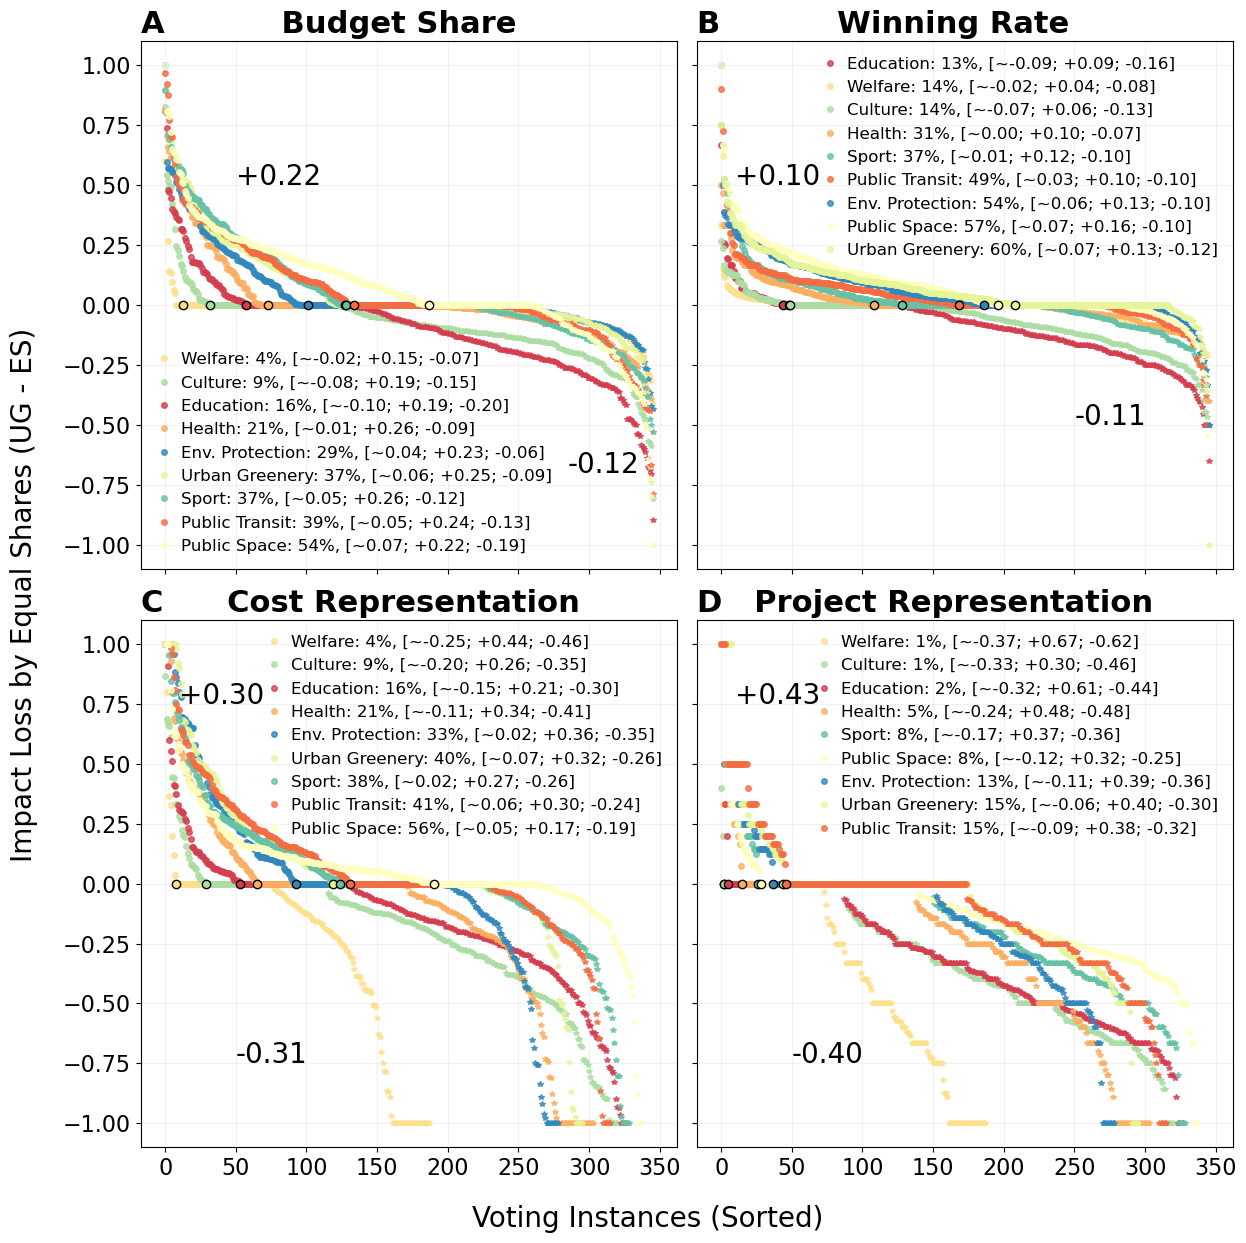

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

## first plot; budget share
bsflippingPoints = {
}

bs_num_election_map = {
}


# First loop through all categories to determine the order of flipping points
for idx, category in enumerate(categories_set):
    threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'diff_greedy_mes_relative_winners_cost_pct_{category}']]
    temp_df.drop_duplicates(inplace=True)
    bs_num_election_map[category] = temp_df[f'diff_greedy_mes_relative_winners_cost_pct_{category}'].count()
    diff_relative_winners_cost_pct_category = temp_df[['election_id', f'diff_greedy_mes_relative_winners_cost_pct_{category}']].sort_values(by=f'diff_greedy_mes_relative_winners_cost_pct_{category}', ascending=False).reset_index()
    
    for i, row in diff_relative_winners_cost_pct_category.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'diff_greedy_mes_relative_winners_cost_pct_{category}'] > 0)):
            bsflippingPoints[category] = i
            threshold_found = True
            break

bsflippingPointsSorted = sorted(bsflippingPoints, key=bsflippingPoints.get)
overall_bs_positive = []
overall_bs_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, category in enumerate(bsflippingPointsSorted):
    # additional metrics for percentage representation
    num_elections = temp_df.shape[0]
    flippingPointVal = bsflippingPoints[category]
    flippingPointPct = 100 * flippingPointVal / bs_num_election_map[category]

    cur_color = categories_color_map[category]
    
    temp_df = categorization_df[['election_id', f'diff_greedy_mes_relative_winners_cost_pct_{category}']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_cost_pct_category = temp_df[['election_id', f'diff_greedy_mes_relative_winners_cost_pct_{category}']].sort_values(by=f'diff_greedy_mes_relative_winners_cost_pct_{category}', ascending=False).reset_index()

    diff_relative_winners_cost_pct_category_avg = np.mean(diff_relative_winners_cost_pct_category[f'diff_greedy_mes_relative_winners_cost_pct_{category}'])
    diff_relative_winners_cost_pct_category_positive_avg = np.mean(diff_relative_winners_cost_pct_category[diff_relative_winners_cost_pct_category[f'diff_greedy_mes_relative_winners_cost_pct_{category}'] > 0][f'diff_greedy_mes_relative_winners_cost_pct_{category}'])
    diff_relative_winners_cost_pct_category_negative_avg = np.mean(diff_relative_winners_cost_pct_category[diff_relative_winners_cost_pct_category[f'diff_greedy_mes_relative_winners_cost_pct_{category}'] < 0][f'diff_greedy_mes_relative_winners_cost_pct_{category}'])

    overall_bs_positive.append(diff_relative_winners_cost_pct_category_positive_avg)
    overall_bs_negative.append(diff_relative_winners_cost_pct_category_negative_avg)

    cur_category_label = f'{category_title_map[category]}: {flippingPointPct:.0f}%, [~{diff_relative_winners_cost_pct_category_avg:.2f}; +{diff_relative_winners_cost_pct_category_positive_avg:.2f}; {diff_relative_winners_cost_pct_category_negative_avg:.2f}]'

    for i, row in diff_relative_winners_cost_pct_category.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[0][0].plot(
                i, row[f'diff_greedy_mes_relative_winners_cost_pct_{category}'],
                marker='o' if row[f'diff_greedy_mes_relative_winners_cost_pct_{category}'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'diff_greedy_mes_relative_winners_cost_pct_{category}'] >= 0 else 'none', 
                label=cur_category_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[0][0].plot(
                    i, row[f'diff_greedy_mes_relative_winners_cost_pct_{category}'], 
                    marker='o' if row[f'diff_greedy_mes_relative_winners_cost_pct_{category}'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, category in enumerate(bsflippingPointsSorted):
    # threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'diff_greedy_mes_relative_winners_cost_pct_{category}']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_cost_pct_category = temp_df[['election_id', f'diff_greedy_mes_relative_winners_cost_pct_{category}']].sort_values(by=f'diff_greedy_mes_relative_winners_cost_pct_{category}', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the category
    flippingPointVal = bsflippingPoints[category]

    for i, row in diff_relative_winners_cost_pct_category.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            # mark such observation with outer black edge color
            axes[0][0].plot(
                    i, row[f'diff_greedy_mes_relative_winners_cost_pct_{category}'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_bs_positive_avg = np.mean(overall_bs_positive)
overall_bs_negative_avg = np.mean(overall_bs_negative)

axes[0][0].annotate(f'+{overall_bs_positive_avg:.2f}', xy=(0, 0), xytext=(50, 0.5), fontsize=20)
axes[0][0].annotate(f'{overall_bs_negative_avg:.2f}', xy=(0, 0), xytext=(285, -0.7), fontsize=20)

axes[0][0].legend(frameon=False, handlelength=1.0, handletextpad=0.5, fontsize=12)
axes[0][0].set_title("A           Budget Share", loc="left", fontsize=22, fontdict={'fontweight': 'bold'})
axes[0][0].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[0][0].tick_params(axis='both', labelsize=16)
## end of first plot

## second plot; winning rate
wrflippingPoints = {
}

wr_num_election_map = {
}

# First loop through all categories to determine the order of flipping points
for idx, category in enumerate(categories_set):
    threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'diff_greedy_mes_relative_winners_count_pct_{category}']]
    temp_df.drop_duplicates(inplace=True)
    wr_num_election_map[category] = temp_df[f'diff_greedy_mes_relative_winners_count_pct_{category}'].count()
    diff_relative_winners_count_pct_category = temp_df[['election_id', f'diff_greedy_mes_relative_winners_count_pct_{category}']].sort_values(by=f'diff_greedy_mes_relative_winners_count_pct_{category}', ascending=False).reset_index()
    
    for i, row in diff_relative_winners_count_pct_category.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'diff_greedy_mes_relative_winners_count_pct_{category}'] > 0)):
            wrflippingPoints[category] = i
            threshold_found = True
            break

wrflippingPointsSorted = sorted(wrflippingPoints, key=wrflippingPoints.get)

overall_wr_positive = []
overall_wr_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, category in enumerate(wrflippingPointsSorted):
    
    # additional metrics for percentage representation for categories in legends
    num_elections = temp_df.shape[0]
    flippingPointVal = wrflippingPoints[category]
    flippingPointPct = 100 * flippingPointVal / wr_num_election_map[category]

    cur_color = categories_color_map[category]
    
    temp_df = categorization_df[['election_id', f'diff_greedy_mes_relative_winners_count_pct_{category}']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_count_pct_category = temp_df[['election_id', f'diff_greedy_mes_relative_winners_count_pct_{category}']].sort_values(by=f'diff_greedy_mes_relative_winners_count_pct_{category}', ascending=False).reset_index()
    
    diff_relative_winners_count_pct_category_avg = np.mean(diff_relative_winners_count_pct_category[f'diff_greedy_mes_relative_winners_count_pct_{category}'])
    diff_relative_winners_count_pct_category_positive_avg = np.mean(diff_relative_winners_count_pct_category[diff_relative_winners_count_pct_category[f'diff_greedy_mes_relative_winners_count_pct_{category}'] > 0][f'diff_greedy_mes_relative_winners_count_pct_{category}'])
    diff_relative_winners_count_pct_category_negative_avg = np.mean(diff_relative_winners_count_pct_category[diff_relative_winners_count_pct_category[f'diff_greedy_mes_relative_winners_count_pct_{category}'] < 0][f'diff_greedy_mes_relative_winners_count_pct_{category}'])
    
    overall_wr_positive.append(diff_relative_winners_count_pct_category_positive_avg)
    overall_wr_negative.append(diff_relative_winners_count_pct_category_negative_avg)
    
    cur_category_label = f'{category_title_map[category]}: {flippingPointPct:.0f}%, [~{diff_relative_winners_count_pct_category_avg:.2f}; +{diff_relative_winners_count_pct_category_positive_avg:.2f}; {diff_relative_winners_count_pct_category_negative_avg:.2f}]'

    for i, row in diff_relative_winners_count_pct_category.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[0][1].plot(
                i, row[f'diff_greedy_mes_relative_winners_count_pct_{category}'],
                marker='o' if row[f'diff_greedy_mes_relative_winners_count_pct_{category}'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'diff_greedy_mes_relative_winners_count_pct_{category}'] >= 0 else 'none', 
                label=cur_category_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[0][1].plot(
                    i, row[f'diff_greedy_mes_relative_winners_count_pct_{category}'], 
                    marker='o' if row[f'diff_greedy_mes_relative_winners_count_pct_{category}'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, category in enumerate(wrflippingPointsSorted):
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'diff_greedy_mes_relative_winners_count_pct_{category}']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_winners_count_pct_category = temp_df[['election_id', f'diff_greedy_mes_relative_winners_count_pct_{category}']].sort_values(by=f'diff_greedy_mes_relative_winners_count_pct_{category}', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the category
    flippingPointVal = wrflippingPoints[category]

    for i, row in diff_relative_winners_count_pct_category.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            # mark such observation with outer black edge color
            axes[0][1].plot(
                    i, row[f'diff_greedy_mes_relative_winners_count_pct_{category}'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_wr_positive_avg = np.mean(overall_wr_positive)
overall_wr_negative_avg = np.mean(overall_wr_negative)

axes[0][1].annotate(f'+{overall_wr_positive_avg:.2f}', xy=(0, 0), xytext=(10, 0.5), fontsize=20)
axes[0][1].annotate(f'{overall_wr_negative_avg:.2f}', xy=(0, 0), xytext=(250, -0.5), fontsize=20)

axes[0][1].legend(frameon=False, handlelength=1.0, handletextpad=0.5, fontsize=12)
axes[0][1].set_title("B           Winning Rate", loc="left", fontsize=22, fontdict={'fontweight': 'bold'})
axes[0][1].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[0][0].tick_params(axis='both', labelsize=16)
## end of second plot

## third plot; cost representation
crflippingPoints = {
}

cr_num_election_map = {
}

# First loop through all categories to determine the order of flipping points
for idx, category in enumerate(categories_set):
    threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'diff_greedy_mes_relative_proposals_cost_pct_{category}']]
    temp_df.drop_duplicates(inplace=True)
    cr_num_election_map[category] = temp_df[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'].count()
    diff_relative_proposals_cost_pct_category = temp_df[['election_id', f'diff_greedy_mes_relative_proposals_cost_pct_{category}']].sort_values(by=f'diff_greedy_mes_relative_proposals_cost_pct_{category}', ascending=False).reset_index()
    
    for i, row in diff_relative_proposals_cost_pct_category.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'] > 0)):
            crflippingPoints[category] = i
            threshold_found = True
            break

crflippingPointsSorted = sorted(crflippingPoints, key=crflippingPoints.get)

overall_cr_positive = []
overall_cr_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, category in enumerate(crflippingPointsSorted):
    
    # additional metrics for percentage representation for categories in legends
    num_elections = temp_df.shape[0]
    flippingPointVal = crflippingPoints[category]
    flippingPointPct = 100 * flippingPointVal / cr_num_election_map[category]

    cur_color = categories_color_map[category]
    
    temp_df = categorization_df[['election_id', f'diff_greedy_mes_relative_proposals_cost_pct_{category}']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_proposals_cost_pct_category = temp_df[['election_id', f'diff_greedy_mes_relative_proposals_cost_pct_{category}']].sort_values(by=f'diff_greedy_mes_relative_proposals_cost_pct_{category}', ascending=False).reset_index()
    
    diff_relative_proposals_cost_pct_category_avg = np.mean(diff_relative_proposals_cost_pct_category[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'])
    diff_relative_proposals_cost_pct_category_positive_avg = np.mean(diff_relative_proposals_cost_pct_category[diff_relative_proposals_cost_pct_category[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'] > 0][f'diff_greedy_mes_relative_proposals_cost_pct_{category}'])
    diff_relative_proposals_cost_pct_category_negative_avg = np.mean(diff_relative_proposals_cost_pct_category[diff_relative_proposals_cost_pct_category[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'] < 0][f'diff_greedy_mes_relative_proposals_cost_pct_{category}'])
    
    overall_cr_positive.append(diff_relative_proposals_cost_pct_category_positive_avg)
    overall_cr_negative.append(diff_relative_proposals_cost_pct_category_negative_avg)
    
    cur_category_label = f'{category_title_map[category]}: {flippingPointPct:.0f}%, [~{diff_relative_proposals_cost_pct_category_avg:.2f}; +{diff_relative_proposals_cost_pct_category_positive_avg:.2f}; {diff_relative_proposals_cost_pct_category_negative_avg:.2f}]'

    for i, row in diff_relative_proposals_cost_pct_category.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[1][0].plot(
                i, row[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'],
                marker='o' if row[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'] >= 0 else 'none', 
                label=cur_category_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[1][0].plot(
                    i, row[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'], 
                    marker='o' if row[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, category in enumerate(crflippingPointsSorted):
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'diff_greedy_mes_relative_proposals_cost_pct_{category}']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_proposals_cost_pct_category = temp_df[['election_id', f'diff_greedy_mes_relative_proposals_cost_pct_{category}']].sort_values(by=f'diff_greedy_mes_relative_proposals_cost_pct_{category}', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the category
    flippingPointVal = crflippingPoints[category]

    for i, row in diff_relative_proposals_cost_pct_category.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            # mark such observation with outer black edge color
            axes[1][0].plot(
                    i, row[f'diff_greedy_mes_relative_proposals_cost_pct_{category}'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_cr_positive_avg = np.mean(overall_cr_positive)
overall_cr_negative_avg = np.mean(overall_cr_negative)

axes[1][0].annotate(f'+{overall_cr_positive_avg:.2f}', xy=(0, 0), xytext=(10, 0.75), fontsize=20)
axes[1][0].annotate(f'{overall_cr_negative_avg:.2f}', xy=(0, 0), xytext=(50, -0.75), fontsize=20)

axes[1][0].legend(frameon=False, handlelength=1.0, handletextpad=0.5, fontsize=12)
axes[1][0].set_title("C      Cost Representation", loc="left", fontsize=22, fontdict={'fontweight': 'bold'})
axes[1][0].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[1][0].tick_params(axis='both', labelsize=16)
## end of third plot

## fourth plot; project representation
rrflippingPoints = {
}

rr_num_election_map = {
}

# First loop through all categories to determine the order of flipping points
for idx, category in enumerate(categories_set):
    threshold_found = False
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'diff_greedy_mes_relative_proposals_count_pct_{category}']]
    temp_df.drop_duplicates(inplace=True)
    rr_num_election_map[category] = temp_df[f'diff_greedy_mes_relative_proposals_count_pct_{category}'].count()
    diff_relative_proposals_count_pct_category = temp_df[['election_id', f'diff_greedy_mes_relative_proposals_count_pct_{category}']].sort_values(by=f'diff_greedy_mes_relative_proposals_count_pct_{category}', ascending=False).reset_index()
    
    for i, row in diff_relative_proposals_count_pct_category.iterrows():
        # Condition check for finding threshold
        if (threshold_found  == False) and (~(row[f'diff_greedy_mes_relative_proposals_count_pct_{category}'] > 0)):
            rrflippingPoints[category] = i
            threshold_found = True
            break

rrflippingPointsSorted = sorted(rrflippingPoints, key=rrflippingPoints.get)

overall_rr_positive = []
overall_rr_negative = []

# Second loop across all categories set to actually plot the lines in the flipping order
for idx, category in enumerate(rrflippingPointsSorted):
    
    # additional metrics for percentage representation for categories in legends
    num_elections = temp_df.shape[0]
    flippingPointVal = rrflippingPoints[category]
    flippingPointPct = 100 * flippingPointVal / rr_num_election_map[category]

    cur_color = categories_color_map[category]
    
    temp_df = categorization_df[['election_id', f'diff_greedy_mes_relative_proposals_count_pct_{category}']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_proposals_count_pct_category = temp_df[['election_id', f'diff_greedy_mes_relative_proposals_count_pct_{category}']].sort_values(by=f'diff_greedy_mes_relative_proposals_count_pct_{category}', ascending=False).reset_index()
    
    diff_relative_proposals_count_pct_category_avg = np.mean(diff_relative_proposals_count_pct_category[f'diff_greedy_mes_relative_proposals_count_pct_{category}'])
    diff_relative_proposals_count_pct_category_positive_avg = np.mean(diff_relative_proposals_count_pct_category[diff_relative_proposals_count_pct_category[f'diff_greedy_mes_relative_proposals_count_pct_{category}'] > 0][f'diff_greedy_mes_relative_proposals_count_pct_{category}'])
    diff_relative_proposals_count_pct_category_negative_avg = np.mean(diff_relative_proposals_count_pct_category[diff_relative_proposals_count_pct_category[f'diff_greedy_mes_relative_proposals_count_pct_{category}'] < 0][f'diff_greedy_mes_relative_proposals_count_pct_{category}'])

    overall_rr_positive.append(diff_relative_proposals_count_pct_category_positive_avg)
    overall_rr_negative.append(diff_relative_proposals_count_pct_category_negative_avg)

    cur_category_label = f'{category_title_map[category]}: {flippingPointPct:.0f}%, [~{diff_relative_proposals_count_pct_category_avg:.2f}; +{diff_relative_proposals_count_pct_category_positive_avg:.2f}; {diff_relative_proposals_count_pct_category_negative_avg:.2f}]'

    for i, row in diff_relative_proposals_count_pct_category.iterrows():
        # additional condition to any specific row data, just for labeling
        if i == 0:
            axes[1][1].plot(
                i, row[f'diff_greedy_mes_relative_proposals_count_pct_{category}'],
                marker='o' if row[f'diff_greedy_mes_relative_proposals_count_pct_{category}'] >= 0 else '*', 
                markerfacecolor= cur_color, 
                markeredgewidth=1, 
                markeredgecolor=cur_color if row[f'diff_greedy_mes_relative_proposals_count_pct_{category}'] >= 0 else 'none', 
                label=cur_category_label, 
                markersize=4, 
                alpha=0.8,
                linestyle='none'
            )
        else:
            axes[1][1].plot(
                    i, row[f'diff_greedy_mes_relative_proposals_count_pct_{category}'], 
                    marker='o' if row[f'diff_greedy_mes_relative_proposals_count_pct_{category}'] >= 0 else '*', 
                    markerfacecolor= cur_color, 
                    markeredgewidth=1, 
                    markeredgecolor=cur_color, 
                    markersize=4, 
                    alpha=0.8,
                    linestyle='none'
                )
            
# Third loop across to present the flipping point value on the outermost layer
for idx, category in enumerate(rrflippingPointsSorted):
    cur_color = categories_color_map[category]
    temp_df = categorization_df[['election_id', f'diff_greedy_mes_relative_proposals_count_pct_{category}']]
    temp_df.drop_duplicates(inplace=True)
    diff_relative_proposals_count_pct_category = temp_df[['election_id', f'diff_greedy_mes_relative_proposals_count_pct_{category}']].sort_values(by=f'diff_greedy_mes_relative_proposals_count_pct_{category}', ascending=False).reset_index()
    
    # additional variable to store flipping point value for the category
    flippingPointVal = rrflippingPoints[category]

    for i, row in diff_relative_proposals_count_pct_category.iterrows():  
        # additional condition check to match the nth item for flipping point value
        if (i == flippingPointVal):
            # mark such observation with outer black edge color
            axes[1][1].plot(
                    i, row[f'diff_greedy_mes_relative_proposals_count_pct_{category}'], 
                    marker='o',
                    markerfacecolor= cur_color, 
                    markeredgecolor='black', 
                )
            
overall_rr_positive_avg = np.mean(overall_rr_positive)
overall_rr_negative_avg = np.mean(overall_rr_negative)

axes[1][1].annotate(f'+{overall_rr_positive_avg:.2f}', xy=(0, 0), xytext=(10, 0.75), fontsize=20)
axes[1][1].annotate(f'{overall_rr_negative_avg:.2f}', xy=(0, 0), xytext=(50, -0.75), fontsize=20)

axes[1][1].legend(frameon=False, handlelength=1.0, handletextpad=0.5, fontsize=12)
axes[1][1].set_title("D   Project Representation", loc="left", fontsize=22, fontdict={'fontweight': 'bold'})
axes[1][1].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[1][1].tick_params(axis='both', labelsize=16)
## end of fourth plot

fig.text(0.5, -0.02, 'Voting Instances (Sorted)', fontsize=20, ha='center', va='center')
fig.text(-0.02, 0.5, 'Impact Loss by Equal Shares (UG - ES)', ha='center', va='center', rotation='vertical', fontsize=20)

plt.tight_layout()
plt.show()